In [1]:
import xarray as xr
from sea_breeze import load_model_data
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
import pandas as pd
import datetime as dt
import tqdm

In [2]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39953,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:36267,Total threads: 2
Dashboard: /proxy/46057/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:35357,


In [3]:
angle_list = []
for m in ["aus2200","barra_c","barra_r","era5"]:
    angle_ds = load_model_data.get_coastline_angle_kernel(
        compute=False,
        path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
        lat_slice=slice(-45.7,-6.9),
        lon_slice=slice(108,158.5)
    )
    angle_list.append(angle_ds)

In [4]:
lsm_list = []
aus2200_orog, aus2200_lsm = load_model_data.load_aus2200_static("mjo-elnino2016",slice(108,158.5),slice(-45.7,-6.9))
barra_c_orog, barra_c_lsm = load_model_data.load_barra_static("AUST-04",slice(108,158.5), slice(-45.7,-6.9))
barra_r_orog, barra_r_lsm = load_model_data.load_barra_static("AUS-11",slice(108,158.5), slice(-45.7,-6.9))
era5_orog, era5_lsm, _ = load_model_data.load_era5_static(slice(108,158.5), slice(-45.7,-6.9), "2016-01-01", "2016-01-01")
for lsm in [aus2200_lsm, barra_c_lsm, barra_r_lsm, era5_lsm]:
    lsm_list.append(lsm)

In [5]:
#Calculate the local solar time offset for all longitudes from the UM


def get_lst_da(ds):

    lst_da_ls = []
    for h in tqdm.tqdm(np.arange(0,24)):
        lst = [dt.datetime(2000,1,1,h) + dt.timedelta(hours=l / 180 * 12) for l in ds.lon.values]
        lst = np.array(pd.to_datetime(lst).round("h").hour)
        lst_arr = np.repeat(lst[np.newaxis,:],ds.lat.shape,axis=0)
        lst_da = xr.DataArray(data=lst_arr,dims=["lat","lon"],coords={"lat":ds.lat,"lon":ds.lon})
        lst_da_ls.append(lst_da)
    
    lst_da = xr.concat(lst_da_ls,dim="hour")
    lst_da = lst_da.assign_coords({"hour":np.arange(0,24)})
    
    return lst_da

lst_da_ls = []
for lsm in lsm_list:
    lst_da_ls.append(get_lst_da(lsm))

100%|██████████| 24/24 [00:00<00:00, 496.77it/s]


In [6]:
models = ["aus2200_smooth_s4","barra_c_smooth_s2","barra_r","era5"]
xbins = np.arange(-550,575,25)

F_list = []
for m in range(len(models)):
    print(m)
    diurnal_groupby = xr.open_dataset("/g/data/ng72/ab4502/hourly_composites/"+models[m]+"/F_hourly_composite.nc")
    diurnal_groupby_lt = xr.concat([diurnal_groupby.where(lst_da_ls[m]==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()
    min_coast_dist = xr.where(lsm_list[m],angle_list[m].min_coast_dist,-angle_list[m].min_coast_dist).persist()
    F_list.append(diurnal_groupby_lt.groupby_bins(min_coast_dist,bins=xbins).mean())

0


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 915.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 38.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


1


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 224.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 29.67 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


3


In [7]:
H_list = []
for m in range(len(models)):
    print(m)
    diurnal_groupby = xr.open_dataset("/g/data/ng72/ab4502/hourly_composites/"+models[m]+"/fuzzy_hourly_composite.nc")
    diurnal_groupby_lt = xr.concat([diurnal_groupby.where(lst_da_ls[m]==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()
    min_coast_dist = xr.where(lsm_list[m],angle_list[m].min_coast_dist,-angle_list[m].min_coast_dist).persist()
    H_list.append(diurnal_groupby_lt.groupby_bins(min_coast_dist,bins=xbins).mean())

0


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 915.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 38.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


1


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 224.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 29.67 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


3


In [8]:
sbi_list = []
for m in range(len(models)):
    if m in [1,2]:
        pass
    else:
        print(m)
        diurnal_groupby = xr.open_dataset("/g/data/ng72/ab4502/hourly_composites/"+models[m]+"/sbi_hourly_composite.nc")
        diurnal_groupby_lt = xr.concat([diurnal_groupby.where(lst_da_ls[m]==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()
        min_coast_dist = xr.where(lsm_list[m],angle_list[m].min_coast_dist,-angle_list[m].min_coast_dist).persist()
        sbi_list.append(diurnal_groupby_lt.groupby_bins(min_coast_dist,bins=xbins).mean())

0


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 915.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 38.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


3


In [9]:
f_lists = [
    ["/g/data/ng72/ab4502/hourly_composites/aus2200/aus2200_hourly_perturbation_uas_vas_201301010000_201301312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200/aus2200_hourly_perturbation_uas_vas_201302010000_201302282300.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200/aus2200_hourly_perturbation_uas_vas_201601010000_201601312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200/aus2200_hourly_perturbation_uas_vas_201602010000_201602292300.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200/aus2200_hourly_perturbation_uas_vas_201801010000_201801312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200/aus2200_hourly_perturbation_uas_vas_201802010000_201802282300.nc"],

    ["/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_uas_vas_201301010000_201301312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_uas_vas_201302010000_201302282300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_uas_vas_201601010000_201601312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_uas_vas_201602010000_201602292300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_uas_vas_201801010000_201801312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_uas_vas_201802010000_201802282300.nc"],

    ["/g/data/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_perturbation_uas_vas_201301010000_201301312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_perturbation_uas_vas_201302010000_201302282300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_perturbation_uas_vas_201601010000_201601312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_perturbation_uas_vas_201602010000_201602292300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_perturbation_uas_vas_201801010000_201801312300.nc",
    "/g/data/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_perturbation_uas_vas_201802010000_201802282300.nc"],

    ["/g/data/ng72/ab4502/hourly_composites/era5/era5_hourly_perturbation_201301010000_201301312300.nc",
     "/g/data/ng72/ab4502/hourly_composites/era5/era5_hourly_perturbation_201302010000_201302282300.nc",
     "/g/data/ng72/ab4502/hourly_composites/era5/era5_hourly_perturbation_201601010000_201601312300.nc",
     "/g/data/ng72/ab4502/hourly_composites/era5/era5_hourly_perturbation_201602010000_201602292300.nc",
     "/g/data/ng72/ab4502/hourly_composites/era5/era5_hourly_perturbation_201801010000_201801312300.nc",
     "/g/data/ng72/ab4502/hourly_composites/era5/era5_hourly_perturbation_201802010000_201802282300.nc"]

]

vprime_pert_list = []
for m in range(len(models)):
    print(models[m])
    upert = xr.concat([xr.open_dataset(f) for f in f_lists[m]],dim="month").mean("month").persist()
    upert_lt = xr.concat([upert.where(lst_da_ls[m]==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()
    min_coast_dist = xr.where(lsm_list[m],angle_list[m].min_coast_dist,-angle_list[m].min_coast_dist).persist()
    vprime_pert_list.append(upert_lt.groupby_bins(min_coast_dist,bins=xbins).mean())

aus2200_smooth_s4


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 915.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 38.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


barra_c_smooth_s2


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 224.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


barra_r


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 29.67 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


era5


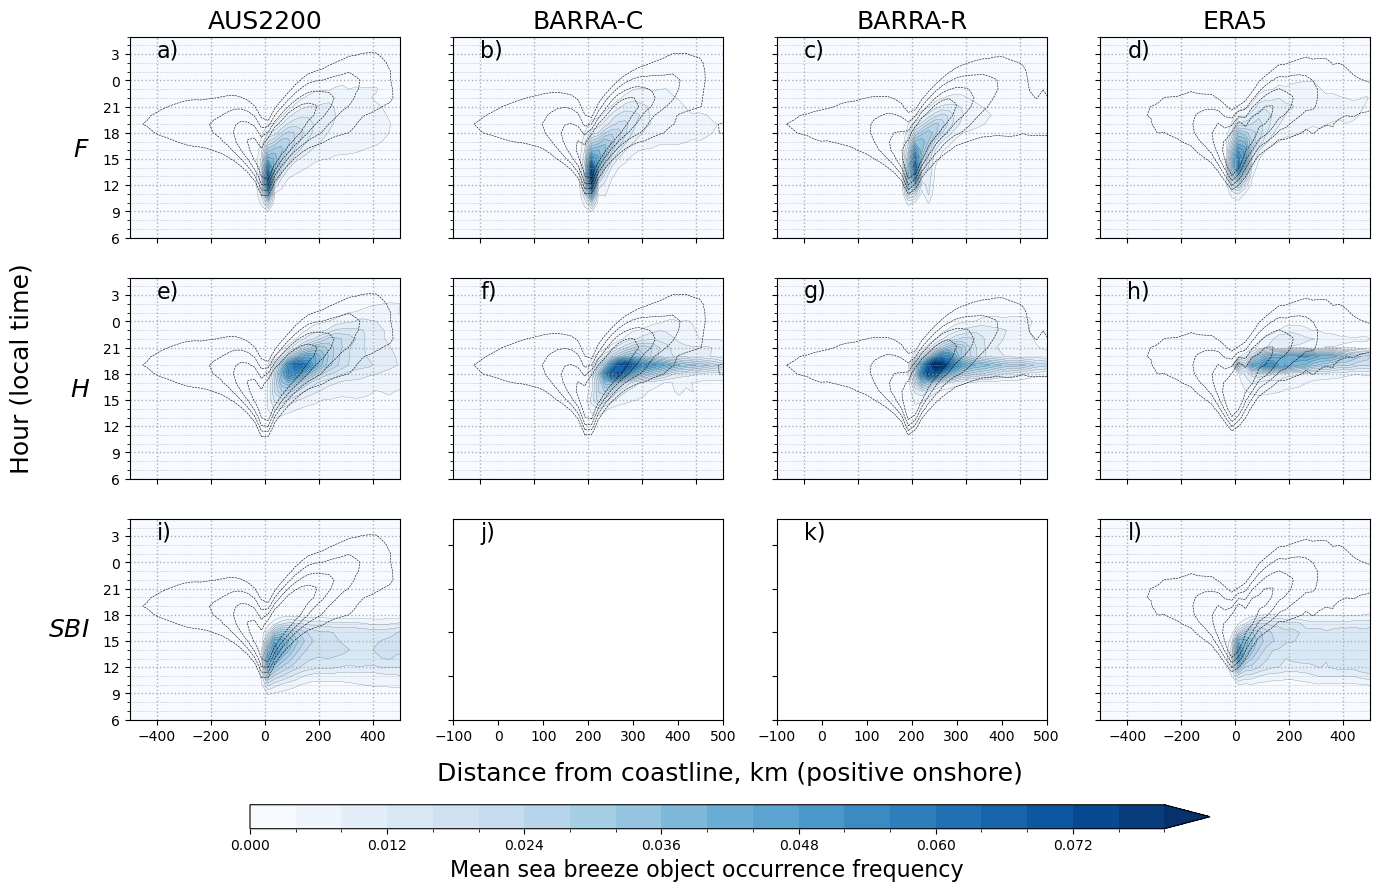

In [10]:
def plot(da,ax,u_da=None):
    hour_reindex = list(np.arange(6,24)) + list(np.arange(0,6))
    cf=xr.plot.contourf(da.sel(hour=hour_reindex),cmap="Blues",levels=np.linspace(0,0.08,21),add_colorbar=False,extend="max")
    xr.plot.contour(da.sel(hour=hour_reindex),colors="k",levels=np.linspace(0.004,0.08,20),linewidths=0.1)
    plt.yticks(np.arange(24),minor=True)
    plt.gca().grid(ls=":",lw=1)
    plt.gca().grid(ls=":",which="minor",lw=0.5)
    if u_da is not None:
        xr.plot.contour(u_da.sel(hour=hour_reindex),levels=[0.25,0.5,0.75,1],colors="k",linewidths=0.4,linestyles="--")
    
    plt.title("")
    plt.xlabel("")
    plt.ylabel("")

    plt.yticks(ticks=np.arange(0,24)[0:-1:3],labels=hour_reindex[0:-1:3]);

    plt.xlim([-500,500])
    
    return cf
    
fig=plt.figure(figsize=[16,12])

ax=plt.subplot(4,4,1)
plot(F_list[0].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); plt.title("AUS2200",size=18)
ax.text(0.1,0.9,"a)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,2)
plot(F_list[1].mask,ax,vprime_pert_list[1].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels(""); plt.title("BARRA-C",size=18)
ax.text(0.1,0.9,"b)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,3)
plot(F_list[2].mask,ax,vprime_pert_list[2].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels(""); plt.title("BARRA-R",size=18)
ax.text(0.1,0.9,"c)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,4)
plot(F_list[3].mask,ax,vprime_pert_list[3].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels(""); plt.title("ERA5",size=18)
ax.text(0.1,0.9,"d)",size=16, transform=ax.transAxes)


ax=plt.subplot(4,4,5)
plot(H_list[0].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels("")
ax.text(0.1,0.9,"e)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,6)
plot(H_list[1].mask,ax,vprime_pert_list[1].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
ax.text(0.1,0.9,"f)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,7)
plot(H_list[2].mask,ax,vprime_pert_list[2].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
ax.text(0.1,0.9,"g)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,8)
plot(H_list[3].mask,ax,vprime_pert_list[3].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
ax.text(0.1,0.9,"h)",size=16, transform=ax.transAxes)




ax=plt.subplot(4,4,9)
plot(sbi_list[0].mask,ax,vprime_pert_list[0].vprime_pert)
ax.text(0.1,0.9,"i)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,10)
#plot(H_list[1].mask,ax)
plt.xlim([-100,500]); plt.ylim([0,23]); ax.set_yticklabels("")
ax.text(0.1,0.9,"j)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,11)
#plot(H_list[2].mask,ax)
plt.xlim([-100,500]); plt.ylim([0,23]); ax.set_yticklabels("")
ax.text(0.1,0.9,"k)",size=16, transform=ax.transAxes)

ax=plt.subplot(4,4,12)
cf=plot(sbi_list[1].mask,ax,vprime_pert_list[3].vprime_pert)
ax.set_yticklabels("")
ax.text(0.1,0.9,"l)",size=16, transform=ax.transAxes)

fig.text(0.05,0.52,"Hour (local time)",rotation=90,size=18)
fig.text(0.1,0.78,"$F$",rotation=0,size=18,ha="right")
fig.text(0.1,0.58,"$H$",rotation=0,size=18,ha="right")
fig.text(0.1,0.38,"$SBI$",rotation=0,size=18,ha="right")
fig.text(0.5,0.26,"Distance from coastline, km (positive onshore)",size=18,ha="center")

cb=plt.colorbar(cf,plt.axes([0.2,0.22,0.6,0.02]),orientation="horizontal")
cb.set_label("Mean sea breeze object occurrence frequency",size=16)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/diurnal_hovmoller.jpeg",bbox_inches="tight",dpi=500)

In [11]:

xbins = np.arange(-550,575,25)


m = 0

f_list = [
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s2/F_smooth1_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s6/F_smooth2_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_orientation1_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_orientation2_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_aspect1_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_aspect2_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_area1_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_area2_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_percentile1_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_percentile2_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_land_sea1_hourly_composite.nc",
    "/g/data/ng72/ab4502/hourly_composites/aus2200_smooth_s4/F_prop_speed1_hourly_composite.nc"
]

sens_list = []
for f in tqdm.tqdm(f_list):
    diurnal_groupby = xr.open_dataset(f)
    diurnal_groupby_lt = xr.concat([diurnal_groupby.where(lst_da_ls[m]==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()
    min_coast_dist = xr.where(lsm_list[m],angle_list[m].min_coast_dist,-angle_list[m].min_coast_dist).persist()
    sens_list.append(diurnal_groupby_lt.groupby_bins(min_coast_dist,bins=xbins).mean())

  0%|          | 0/12 [00:00<?, ?it/s]/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 915.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 38.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
  8%|▊         | 1/12 [00:33<06:13, 33.92s/it]/g/data/xp65/pu

2025-07-21 11:42:35,512 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 7.23 GiB -- Worker memory limit: 9.00 GiB
2025-07-21 11:42:37,594 - distributed.worker.memory - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 5.01 GiB -- Worker memory limit: 9.00 GiB
2025-07-21 11:42:48,214 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 7.24 GiB -- Worker memory limit: 9.00 GiB
2025-07-21 11:42:50,468 - distributed.worker.memory - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 5.00 GiB -- Worker memory limit: 9.00 GiB
2025-07-21 11:42:54,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.30 GiB 

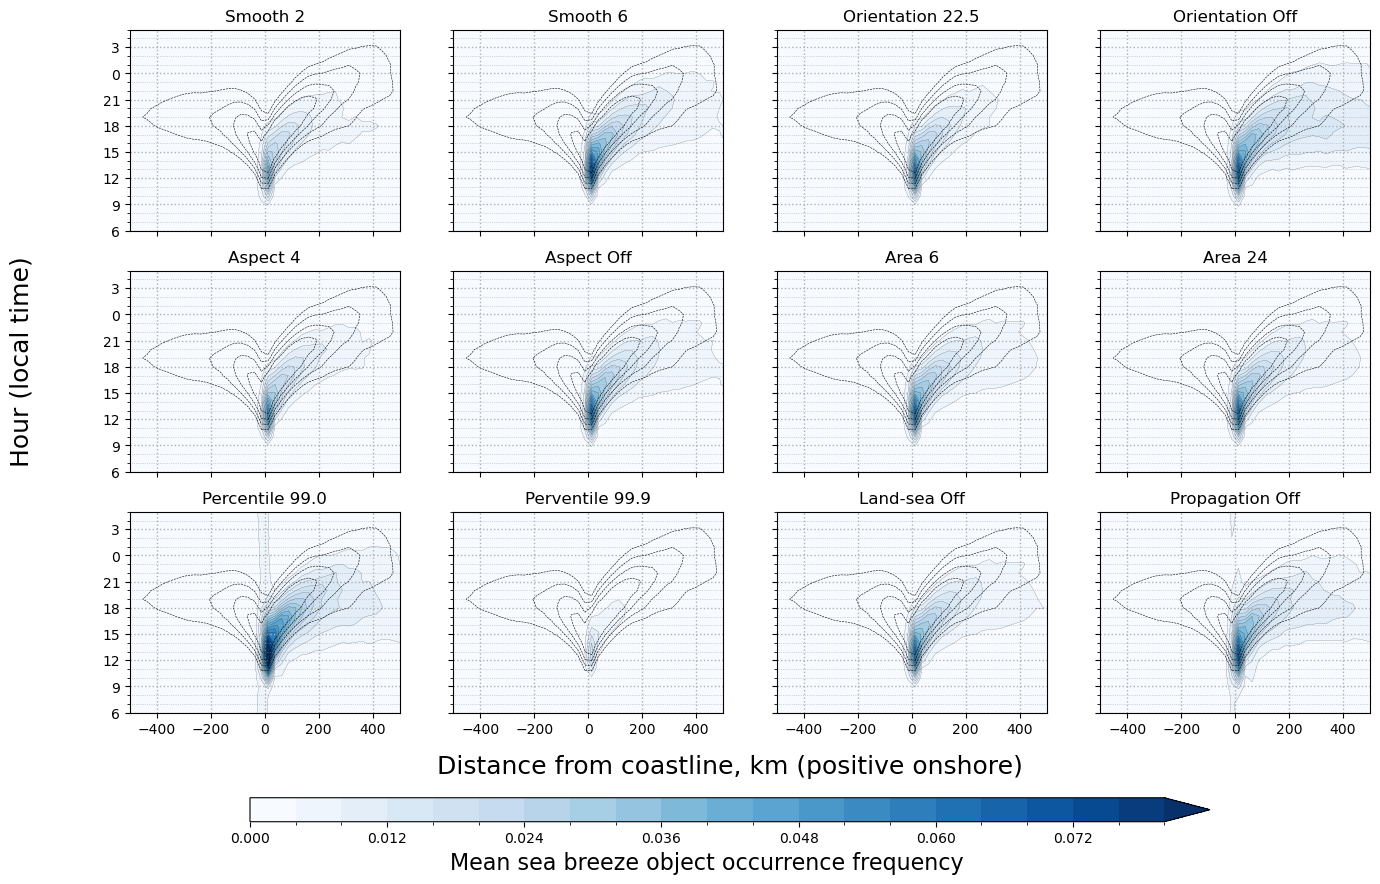

In [12]:
fig=plt.figure(figsize=[16,12])

ax=plt.subplot(4,4,1)
plot(sens_list[0].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels("")
plt.title("Smooth 2")

ax=plt.subplot(4,4,2)
plot(sens_list[1].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
plt.title("Smooth 6")

ax=plt.subplot(4,4,3)
plot(sens_list[2].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
plt.title("Orientation 22.5")

ax=plt.subplot(4,4,4)
plot(sens_list[3].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
plt.title("Orientation Off")


ax=plt.subplot(4,4,5)
plot(sens_list[4].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels("")
plt.title("Aspect 4")

ax=plt.subplot(4,4,6)
plot(sens_list[5].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
plt.title("Aspect Off")

ax=plt.subplot(4,4,7)
plot(sens_list[6].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
plt.title("Area 6")

ax=plt.subplot(4,4,8)
plot(sens_list[7].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_xticklabels(""); ax.set_yticklabels("")
plt.title("Area 24")


ax=plt.subplot(4,4,9)
plot(sens_list[8].mask,ax,vprime_pert_list[0].vprime_pert)
plt.title("Percentile 99.0")

ax=plt.subplot(4,4,10)
plot(sens_list[9].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_yticklabels("")
plt.title("Perventile 99.9")

ax=plt.subplot(4,4,11)
plot(sens_list[10].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_yticklabels("")
plt.title("Land-sea Off")

ax=plt.subplot(4,4,12)
cf=plot(sens_list[11].mask,ax,vprime_pert_list[0].vprime_pert)
ax.set_yticklabels("")
plt.title("Propagation Off")


fig.text(0.05,0.52,"Hour (local time)",rotation=90,size=18)
fig.text(0.5,0.26,"Distance from coastline, km (positive onshore)",size=18,ha="center")

cb=plt.colorbar(cf,plt.axes([0.2,0.22,0.6,0.02]),orientation="horizontal")
cb.set_label("Mean sea breeze object occurrence frequency",size=16)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/diurnal_hovmoller_sensitivity_test.jpeg",bbox_inches="tight",dpi=500)